<h3>Portfolio Optimisation Analysis</h3>

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

In [41]:
#Load in ETF price data into one dataframe with close prices and dates

vwrl_json = json.load(open('VWRL_Prices.json'))
vwrl_prices = pd.DataFrame.from_dict(vwrl_json.get('history'),orient='index').reset_index()
vwrl_prices.rename(columns={"index":"Date", "close":"VWRL"}, inplace=True)
vwrl_prices = vwrl_prices[["Date","VWRL"]]

vmid_json = json.load(open('VMID_Prices.json'))
vmid_prices = pd.DataFrame.from_dict(vmid_json.get('history'),orient='index').reset_index()
vmid_prices.rename(columns={"index":"Date","close":"VMID"}, inplace=True)
vmid_prices = vmid_prices[["Date","VMID"]]

vfem_json = json.load(open('VFEM_Prices.json'))
vfem_prices = pd.DataFrame.from_dict(vfem_json.get('history'),orient='index').reset_index()
vfem_prices.rename(columns={"index":"Date","close":"VFEM"}, inplace=True)
vfem_prices = vfem_prices[["Date","VFEM"]]

#Merge all etfs into one dataframe joined on Date
etfs = pd.merge(left=vwrl_prices, right=vmid_prices, left_on='Date', right_on='Date', how='inner')
etfs = pd.merge(left=etfs, right=vfem_prices, left_on='Date', right_on='Date', how='inner')

etfs = etfs.sort_values(by='Date',ascending=True)
etfs = etfs.set_index('Date')

print(etfs.dtypes)
print(etfs.head(5))

VWRL    object
VMID    object
VFEM    object
dtype: object
             VWRL   VMID   VFEM
Date                           
2019-10-01  69.74  31.31  44.58
2019-10-02  67.92  30.70  43.96
2019-10-03  67.54  30.51  43.92
2019-10-04  68.78  30.74  44.57
2019-10-07  69.07  30.63  44.50


In [42]:
#Convert to floats
etfs['VFEM'] = pd.to_numeric(etfs['VFEM'])
etfs['VMID'] = pd.to_numeric(etfs['VMID'])
etfs['VWRL'] = pd.to_numeric(etfs['VWRL'])
print(etfs.dtypes)
print(etfs.head(5))

VWRL    float64
VMID    float64
VFEM    float64
dtype: object
             VWRL   VMID   VFEM
Date                           
2019-10-01  69.74  31.31  44.58
2019-10-02  67.92  30.70  43.96
2019-10-03  67.54  30.51  43.92
2019-10-04  68.78  30.74  44.57
2019-10-07  69.07  30.63  44.50


In [43]:
#Normalise prices using logarithmic returns
etfs_log_rtn = np.log(etfs/etfs.shift(1))
print(etfs_log_rtn.head(5))

                VWRL      VMID      VFEM
Date                                    
2019-10-01       NaN       NaN       NaN
2019-10-02 -0.026443 -0.019675 -0.014005
2019-10-03 -0.005611 -0.006208 -0.000910
2019-10-04  0.018193  0.007510  0.014691
2019-10-07  0.004207 -0.003585 -0.001572


<h3>Explanation of efficient frontier here</h3>
........

In [50]:
num_random_portfolios = 6000
num_etfs = len(etfs.columns)
all_weights = np.zeros((num_random_portfolios, num_etfs))
exp_rtns = np.zeros(num_random_portfolios)
exp_vols = np.zeros(num_random_portfolios)
exp_sharpe_ratios = np.zeros(num_random_portfolios)

for x in range(num_random_portfolios):
    # Generate random weights
    weights = np.array(np.random.random(num_etfs))
    weights = weights / np.sum(weights)

    # Save the random weights
    all_weights[x, :] = weights

    # Save expected annual returns
    exp_rtns[x] = np.sum((etfs_log_rtn.mean() * weights * 252))

    # Save expected volatilities
    exp_vols[x] = np.sqrt(np.dot(weights.T, np.dot(etfs_log_rtn.cov() * 252, weights)))

    # Save Sharpe Ratios
    exp_sharpe_ratios[x] = exp_rtns[x] / exp_vols[x]

max_sharpe_ratio = exp_sharpe_ratios.max()
max_sharpe_loc = exp_sharpe_ratios.argmax()
print('Maximum Sharpe Ratio: ', max_sharpe_ratio)
print('Its location in the random weights array: ', max_sharpe_loc)

Maximum Sharpe Ratio:  1.7919853931362937
Its location in the random weights array:  1169


In [51]:
print(all_weights[max_sharpe_loc,:])
max_sharpe_rtn = exp_rtns[max_sharpe_loc]
max_sharpe_vol = exp_vols[max_sharpe_loc]

[0.27839489 0.72060615 0.00099896]


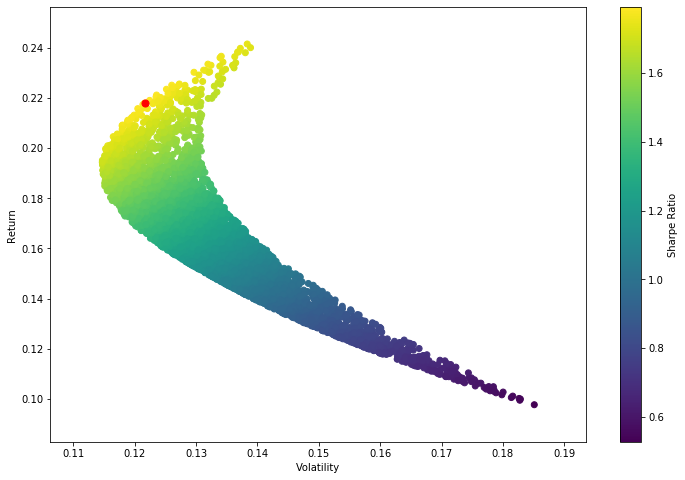

In [52]:
%matplotlib inline
plt.figure(figsize=(12,8))
plt.scatter(exp_vols, exp_rtns, c=exp_sharpe_ratios, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sharpe_vol, max_sharpe_rtn,c='red', s=50) # red dot
plt.show()